## Smooth Power Law Examples

Below are a few examples of the smoothly broken power law rating curve implementation.

In [1]:
from numpy.typing import ArrayLike
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
import sys

if ".." not in sys.path:
    sys.path.insert(0, "..")

Equation for a smoothly broken power law with $n$ breaks is:

\begin{equation}
    f(x) = Ax^{\alpha_0} {\displaystyle \prod^{n}_{i=1}} \Bigg(1 + \bigg(\frac{x}{x_i}\bigg)^{1/\Delta}\Bigg)^{(\alpha_i - \alpha_{i-1})\Delta},
\end{equation}

where $A$ is the scaling amplitude, $\alpha_0$ is the power law slope before the first breakpoint ($x_1$), $\alpha_i$ are the power law slopes between breakpoints $x_{i}$ and $x_{i+1}$ with $i$ being the $i$th breakpoint and $i < n$, $\alpha_n$ is the power law slope after the last breakpoint ($x_n$), and $\Delta$ is the parameter controlling the smoothness of the break. Smaller (non-negative) values of $\Delta$ yield a sharper break, and larger values yield a smoother break.

This equation was adapted from Equation 1 in [Caballero et al. 2023](https://arxiv.org/pdf/2210.14891.pdf).

In log-space:

\begin{equation}
    \log(f(x)) = \log(A) + \alpha_0 \log(x) + {\displaystyle \sum^{n}_{i=1}} (\alpha_i - \alpha_{i-1})\Delta \Bigg(1 + \bigg(\frac{x}{x_i}\bigg)^{1/\Delta}\Bigg),
\end{equation}

In [2]:
def SmoothlyBrokenPowerLaw(x: ArrayLike, amplitude: float, breaks: ArrayLike, alphas: ArrayLike, delta: float) -> np.ndarray:
    breakpoint_array = np.expand_dims(breaks, 0)
    alphas_array = np.array(alphas)
    alphas_diff_array = np.expand_dims(alphas_array[1:] - alphas_array[:-1], 0)
    x_array = np.expand_dims(x, 1)
    prod_array = (1 + (x_array/breakpoint_array) ** (1/delta)) ** (alphas_diff_array * delta)
    fx = amplitude * x ** alphas[0] * np.prod(prod_array, axis=1)
    return fx

Now that we have created to equation function, let's generate some simulated data.

<function matplotlib.pyplot.show(close=None, block=None)>

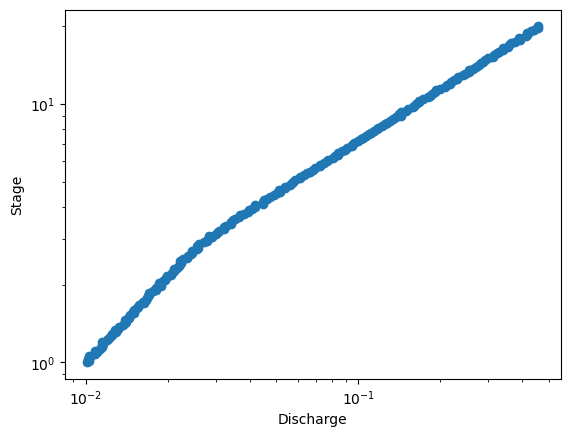

In [3]:
h = np.geomspace(1, 20, 200)
a = 0.01
delta = 0.1
breaks = [3]
alphas = [0.9, 1.5]
q = SmoothlyBrokenPowerLaw(h, a, breaks, alphas, delta)
# Add some random noise in log space
q = np.exp(np.log(q) + np.random.randn(len(q)) * 0.01)

fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.show

Then fit the simulated data and plot the fits.

In [4]:
from ratingcurve.experimental import SmoothPowerLawRating

# initialize the model
smoothpowerrating = SmoothPowerLawRating(q=q,
                                         h=h,
                                         segments=2)
trace = smoothpowerrating.fit()
data = smoothpowerrating.table(trace, h)

Convergence achieved at 59400
Interrupted at 59,399 [29%]: Average Loss = 3.3002e+06


<function matplotlib.pyplot.show(close=None, block=None)>

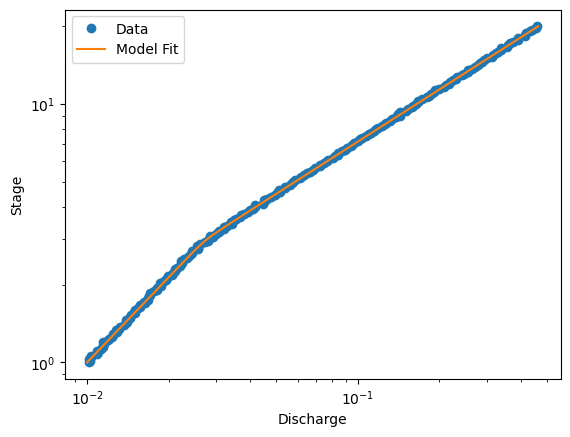

In [5]:
fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='', label='Data')
ax.loglog(data['discharge'], data['stage'], label='Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.legend()
plt.show

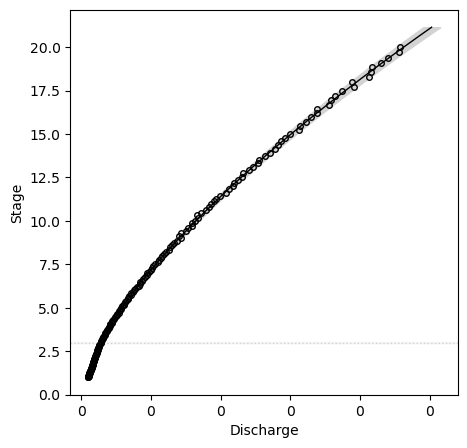

In [6]:
smoothpowerrating.plot(trace)

So, the fit looks good compared to the data. Let's also check the derived values.

In [7]:
print('Power law slopes expected values: '+str(alphas)+', Derived values: '
      +str(trace.posterior.w.mean(axis=1).values.squeeze())+' +/- '+str(trace.posterior.w.std(axis=1).values.squeeze()))
print('Break point expected values: '+str(breaks)+', Derived values: '
      +str(trace.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace.posterior.hs.std(axis=1).values.squeeze()))
print('Normalization expected values: '+str(a)+', Derived values: '
      +str(np.exp(trace.posterior.a.mean().values.squeeze()))+' +/- '+str(np.exp(trace.posterior.a.mean().values.squeeze()) * trace.posterior.a.std().values.squeeze()))
print('Smoothness parameter expected values: '+str(delta)+', Derived values: '
      +str(trace.posterior.delta.mean().values.squeeze())+' +/- '+str(trace.posterior.delta.std().values.squeeze()))

Power law slopes expected values: [0.9, 1.5], Derived values: [0.91366557 1.49102566] +/- [0.00088568 0.00103505]
Break point expected values: [3], Derived values: 2.9889514830290853 +/- 0.005414554626474651
Normalization expected values: 0.01, Derived values: 0.00999556158690344 +/- 8.236175793618322e-06
Smoothness parameter expected values: 0.1, Derived values: 0.041072964783624266 +/- 0.019231396858647925


They look spot on. If this was not the case, would could try refitting using mini-batches, which should improve the exploration of parameter space and minimize the chance of getting stuck in a local minimum.

In [8]:
from ratingcurve.experimental import SmoothPowerLawRating

# initialize the model
smoothpowerrating_mini = SmoothPowerLawRating(q=q,
                                         h=h,
                                         batch_size=100,
                                         segments=2)
trace_mini = smoothpowerrating_mini.fit()
data_mini = smoothpowerrating_mini.table(trace_mini, h)

/home/kdoore/software/miniforge3/envs/ratingcurve/lib/python3.11/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FE1ACB9ACE0>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(


Convergence achieved at 52200
Interrupted at 52,199 [26%]: Average Loss = 1.9358e+06
/home/kdoore/software/miniforge3/envs/ratingcurve/lib/python3.11/site-packages/pymc/backends/arviz.py:65: UserWarning: Could not extract data from symbolic observation mu
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


In [9]:
print('Power law slopes expected values: '+str(alphas)+', Derived values: '
      +str(trace_mini.posterior.w.mean(axis=1).values.squeeze())+' +/- '+str(trace_mini.posterior.w.std(axis=1).values.squeeze()))
print('Break point expected values: '+str(breaks)+', Derived values: '
      +str(trace_mini.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_mini.posterior.hs.std(axis=1).values.squeeze()))
print('Normalization expected values: '+str(a)+', Derived values: '
      +str(np.exp(trace_mini.posterior.a.mean().values.squeeze()))+' +/- '+str(np.exp(trace_mini.posterior.a.mean().values.squeeze()) * trace_mini.posterior.a.std().values.squeeze()))
print('Smoothness parameter expected values: '+str(delta)+', Derived values: '
      +str(trace_mini.posterior.delta.mean().values.squeeze())+' +/- '+str(trace_mini.posterior.delta.std().values.squeeze()))

Power law slopes expected values: [0.9, 1.5], Derived values: [0.91335745 1.48709445] +/- [0.00093589 0.00111696]
Break point expected values: [3], Derived values: 2.965590013316481 +/- 0.006901979585667694
Normalization expected values: 0.01, Derived values: 0.009954533852142098 +/- 9.359203363302961e-06
Smoothness parameter expected values: 0.1, Derived values: 0.04964405000113834 +/- 0.02254732475271156


Again, the mini-batch fitting resulted in good fits. Not quite as good as the regular fit, but still acceptable.

Let's see how this fit compares with the original power law rating.

In [10]:
from ratingcurve.ratingmodel import PowerLawRating

powerrating = PowerLawRating(q=q,
                             h=h, 
                             segments=2)
trace_pl = powerrating.fit()
data_pl = powerrating.table(trace_pl, h)

Convergence achieved at 84200
Interrupted at 84,199 [42%]: Average Loss = 1,402.5


<function matplotlib.pyplot.show(close=None, block=None)>

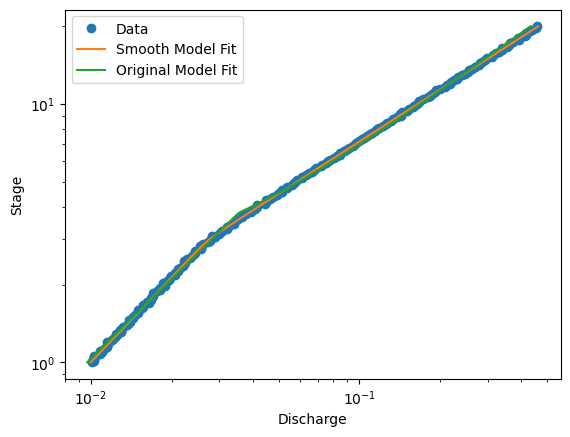

In [11]:
fig, ax = plt.subplots()
ax.loglog(q, h, marker='o', linestyle='', label='Data')
ax.loglog(data['discharge'], data['stage'], label='Smooth Model Fit')
ax.loglog(data_pl['discharge'], data_pl['stage'], label='Original Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage')
plt.legend()
plt.show

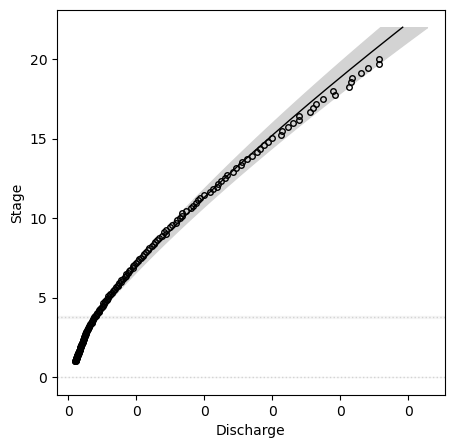

In [12]:
powerrating.plot(trace_pl)

In [13]:
print('Break point expected values: '+str(breaks)+', Derived values: '
      +str(trace_pl.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_pl.posterior.hs.std(axis=1).values.squeeze()))

Break point expected values: [3], Derived values: [3.65684579e-03 3.80121474e+00] +/- [0.00348841 0.03951647]


The original power law model fit the data pretty well considering it was not used to generate the data like the smooth power law model. Now let's test both models on some real data to see how they compare on something less biased toward a certain model.

<function matplotlib.pyplot.show(close=None, block=None)>

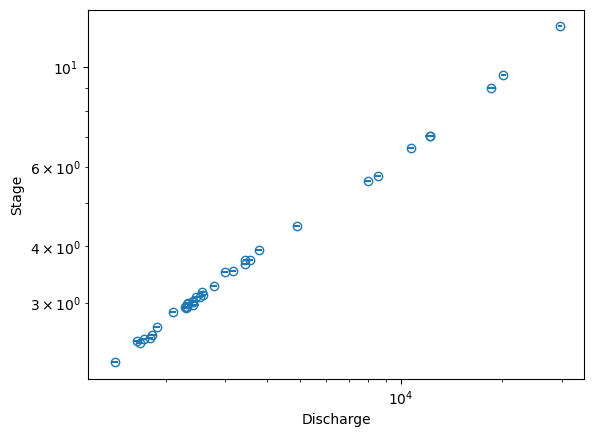

In [14]:
from ratingcurve import data

# load tutorial data
df = data.load('green channel')

fig, ax = plt.subplots()
ax.errorbar(df['q'], df['stage'], xerr=df['q_sigma'], marker='o', linestyle='', fillstyle='none')
ax.set(xlabel='Discharge', ylabel='Stage', xscale='log', yscale='log')
plt.show

In [15]:
# initialize the model
smoothpowerrating_gc = SmoothPowerLawRating(q=df['q'],
                                            h=df['stage'], 
                                            q_sigma=df['q_sigma'],
                                            segments=2)
trace_gc = smoothpowerrating_gc.fit()
data_gc = smoothpowerrating_gc.table(trace_gc, np.geomspace(df['stage'].min(), df['stage'].max(), 201))

Convergence achieved at 48300
Interrupted at 48,299 [24%]: Average Loss = 1.1588e+05


Let's see if using mini-batches helps any.

In [16]:
# initialize the model
smoothpowerrating_gc_mini = SmoothPowerLawRating(q=df['q'],
                                            h=df['stage'], 
                                            q_sigma=df['q_sigma'],
                                            batch_size=18,
                                            segments=2)
trace_gc_mini = smoothpowerrating_gc_mini.fit()
data_gc_mini = smoothpowerrating_gc_mini.table(trace_gc_mini, np.geomspace(df['stage'].min(), df['stage'].max(), 201))

/home/kdoore/software/miniforge3/envs/ratingcurve/lib/python3.11/site-packages/pymc/pytensorf.py:1055: UserWarning: RNG Variable RandomGeneratorSharedVariable(<Generator(PCG64) at 0x7FE19FD6E260>) has multiple clients. This is likely an inconsistent random graph.
  warnings.warn(


Finished [100%]: Average Loss = -13.439
/home/kdoore/software/miniforge3/envs/ratingcurve/lib/python3.11/site-packages/pymc/backends/arviz.py:65: UserWarning: Could not extract data from symbolic observation mu
  warnings.warn(f"Could not extract data from symbolic observation {obs}")


In [17]:
# initialize the model
powerrating_gc = PowerLawRating(q=df['q'],
                                h=df['stage'], 
                                q_sigma=df['q_sigma'],
                                segments=2)
trace_pl_gc = powerrating_gc.fit()
data_pl_gc = powerrating_gc.table(trace_pl_gc, np.geomspace(df['stage'].min(), df['stage'].max(), 201))

Convergence achieved at 76300
Interrupted at 76,299 [38%]: Average Loss = 71.361


<function matplotlib.pyplot.show(close=None, block=None)>

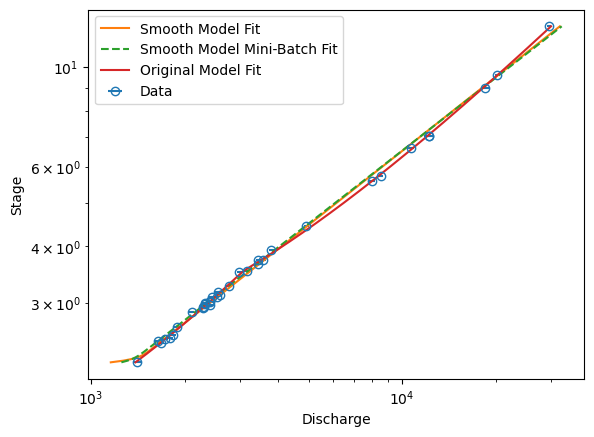

In [18]:
fig, ax = plt.subplots()
ax.errorbar(df['q'], df['stage'], xerr=df['q_sigma'], marker='o', linestyle='', fillstyle='none', label='Data')
ax.loglog(data_gc['discharge'], data_gc['stage'], label='Smooth Model Fit')
ax.loglog(data_gc_mini['discharge'], data_gc_mini['stage'], label='Smooth Model Mini-Batch Fit', linestyle='--')
ax.loglog(data_pl_gc['discharge'], data_pl_gc['stage'], label='Original Model Fit')
ax.set(xlabel='Discharge', ylabel='Stage', xscale='log', yscale='log')
plt.legend()
plt.show

In [19]:
print('Power law slopes derived values: '
      +str(trace_gc.posterior.w.mean(axis=1).values.squeeze())+' +/- '+str(trace_gc.posterior.w.std(axis=1).values.squeeze()))
print('Break point derived values: '
      +str(trace_gc.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_gc.posterior.hs.std(axis=1).values.squeeze()))
print('Smoothness parameter derived values: '
      +str(trace_gc.posterior.delta.mean().values.squeeze())+' +/- '+str(trace_gc.posterior.delta.std().values.squeeze()))

Power law slopes derived values: [21.02750331  1.83024853] +/- [0.01148774 0.01327996]
Break point derived values: 2.216670656907362 +/- 0.000850709419724061
Smoothness parameter derived values: 0.011067121775358122 +/- 0.0012688667927144173


In [20]:
print('Mini-Batch Power law slopes derived values: '
      +str(trace_gc_mini.posterior.w.mean(axis=1).values.squeeze())+' +/- '+str(trace_gc_mini.posterior.w.std(axis=1).values.squeeze()))
print('Mini-Batch Break point derived values: '
      +str(trace_gc_mini.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_gc_mini.posterior.hs.std(axis=1).values.squeeze()))
print('Mini-Batch Smoothness parameter derived values: '
      +str(trace_gc_mini.posterior.delta.mean().values.squeeze())+' +/- '+str(trace_gc_mini.posterior.delta.std().values.squeeze()))

Mini-Batch Power law slopes derived values: [9.94376682 1.85665161] +/- [0.00862827 0.01075616]
Mini-Batch Break point derived values: 2.212386872758942 +/- 0.0014658545017845743
Mini-Batch Smoothness parameter derived values: 0.011412409498186823 +/- 0.001709197627141294


In [21]:
print('Original Model Break point derived values: '
      +str(trace_pl_gc.posterior.hs.mean(axis=1).values.squeeze())+' +/- '+str(trace_pl_gc.posterior.hs.std(axis=1).values.squeeze()))

Original Model Break point derived values: [0.89879436 3.53084215] +/- [0.00769226 0.04473808]


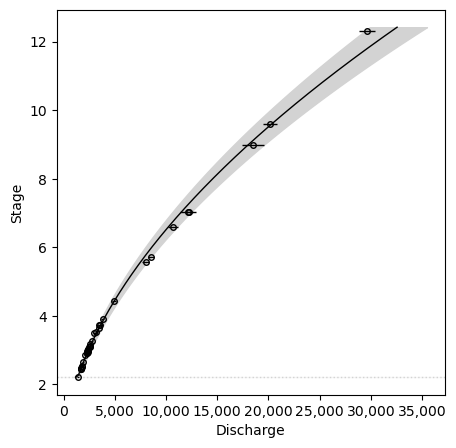

In [22]:
smoothpowerrating_gc.plot(trace_gc)

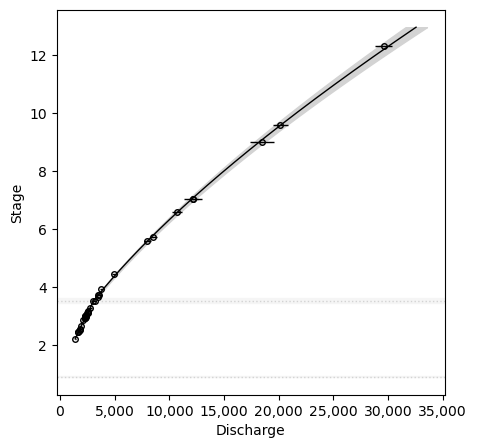

In [23]:
powerrating_gc.plot(trace_pl_gc)